<a href="https://colab.research.google.com/github/SathyaSudha-96/Deep-Learning-2021-22/blob/main/IDL_Assignment_5_SathyaSudhaMurugan_Solution_Trial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import layers
import time
from keras.utils.vis_utils import plot_model

In [2]:
# remove infrequent words. you can play with this parameter as it will likely impact model quality
num_words = 20000
(train_sequences, train_labels), (test_sequences, test_labels) = tf.keras.datasets.imdb.load_data(num_words=num_words)
train_labels = train_labels.reshape(-1)
test_labels = test_labels.reshape(-1)

17473536/17464789 [==============================] - 0s 0us/step


In [3]:
train_sequences[:2]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 82

In [4]:
# labels are simply binary: sentiment can be positive or negative
train_labels[:2]

array([1, 0])

In [5]:
# solution is padding all sequences to the maximum length.
# first find the maximum length
sequence_lengths = [len(sequence) for sequence in train_sequences]
max_len = max(sequence_lengths)
total = sum(sequence_lengths)
length = len(sequence_lengths)
average = total/length
average

238.71364

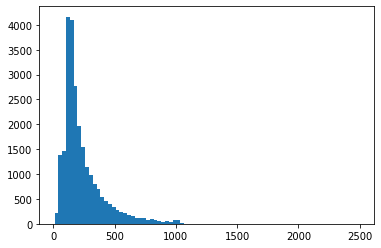

In [6]:
# overview over sequence lengths in the data
# could also look at mean, median, standard deviation...
plt.hist(sequence_lengths, bins=80)
plt.show()

In [7]:
# luckily there is a convenient function for padding
train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=200, truncating='pre')
train_sequences_padded.shape

(25000, 200)

In [8]:
# luckily there is a convenient function for padding
test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=200, truncating='post')
test_sequences_padded.shape

(25000, 200)

In [9]:
print('Train Labels Shape', train_labels.shape)
print('Train Sequence Shape', train_sequences_padded.shape)

Train Labels Shape (25000,)
Train Sequence Shape (25000, 200)


In [10]:
# now we can create a dataset!
train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels.astype(np.int32)))

In [11]:
# now we can create a dataset!
test_data = tf.data.Dataset.from_tensor_slices((test_sequences_padded, test_labels.astype(np.int32)))

In [12]:
train_data = train_data.batch(128, drop_remainder=True)
test_data = test_data.batch(128, drop_remainder=True)

In [13]:
hidden_dim = 200 # unfolded length of recurrent network
output_dim = 1
batch_size = 128
dict_size = 20000

In [14]:
#weights from input to hidden
w_ih = tf.Variable(np.zeros((dict_size,hidden_dim),dtype=np.float32))
b = tf.Variable(np.zeros((hidden_dim,),dtype=np.float32))
#weights from hidden to hidden
w_hh = tf.Variable(np.zeros((hidden_dim, hidden_dim),dtype=np.float32))
 #weights from hidden to output
w_ho = tf.Variable(np.zeros((hidden_dim,output_dim),dtype=np.float32))
c = tf.Variable(np.zeros((output_dim,),dtype=np.float32))


In [15]:
def RNN_model(sequence):
  #old state
  o_state = tf.Variable(np.zeros((batch_size,hidden_dim),dtype=np.float32))
  for step in range(max_len):
    new_state = seq[:,step]
    x_t = tf.one_hot(new_state, depth=dict_size)
    #a(t) = Wh(t-1) + UX(t)
    a1 = tf.matmul(o_state,w_hh)
    a2 = tf.matmul(x_t, w_ih)
    a_t = tf.add(b,a1,a2) #a_t = b + tf.matmul(w_hh,o_state) + tf.matmul(w_ih,x_t)  
    h_t = tf.math.tanh(a_t)   #h(t) = tanh(a(t))
    o_state = h_t #assigning old state with new state
    o_t = tf.add(c, tf.matmul(h_t,w_ho))
    #output = tf.math.sigmoid(c + tf.matmul(w_ho,h_t))  #o(t) = Vh(t)
    output = tf.math.sigmoid(o_t)
    return output

In [16]:
epochs = 30
max_len = 200
loss_function = tf.keras.losses.BinaryCrossentropy()
accuracy = tf.keras.metrics.BinaryAccuracy()
for epoch in range(epochs):
  print('Starting Epoch',epoch+1)
  for step, (sequence_batch, label_batch) in enumerate(train_data):
    seq, lbl = sequence_batch, label_batch
    with tf.GradientTape(persistent=True) as tape:
      output = RNN_model(seq)
      loss = loss_function(lbl,output)
    #Compute gradients  
    gradients = tape.gradient(loss,[w_ih, w_hh, w_ho, b, c])  
    #Apply Gradients
    w_ih.assign_sub = gradients[0]
    w_hh.assign_sub = gradients[1]
    w_ho.assign_sub = gradients[2]
    b.assign_sub = gradients[3]
    c.assign_sub = gradients[4]

    accuracy(lbl,output)
    
    if not step % 100:
      print("Loss: {} Training Accuracy: {}".format(loss, accuracy.result()))

Starting Epoch 1
Loss: 0.6931469440460205 Training Accuracy: 0.578125
Loss: 0.6931469440460205 Training Accuracy: 0.4953589141368866
Starting Epoch 2
Loss: 0.6931469440460205 Training Accuracy: 0.5005580186843872
Loss: 0.6931469440460205 Training Accuracy: 0.49852195382118225
Starting Epoch 3
Loss: 0.6931469440460205 Training Accuracy: 0.5003596544265747
Loss: 0.6931469440460205 Training Accuracy: 0.4991725981235504
Starting Epoch 4
Loss: 0.6931469440460205 Training Accuracy: 0.5002933144569397
Loss: 0.6931469440460205 Training Accuracy: 0.4994533658027649
Starting Epoch 5
Loss: 0.6931469440460205 Training Accuracy: 0.500260055065155
Loss: 0.6931469440460205 Training Accuracy: 0.4996098279953003
Starting Epoch 6
Loss: 0.6931469440460205 Training Accuracy: 0.5002401471138
Loss: 0.6931469440460205 Training Accuracy: 0.4997095763683319
Starting Epoch 7
Loss: 0.6931469440460205 Training Accuracy: 0.5002268552780151
Loss: 0.6931469440460205 Training Accuracy: 0.49977871775627136
Starting Ep

In [17]:
for step, (sequence_batch, label_batch) in enumerate(test_data):
  seq, lbl = sequence_batch, label_batch
  output = RNN_model(seq)
  loss = loss_function(lbl,output)
  accuracy(lbl,output)
print('Testing Accuracy:', format(accuracy.result()))    

Testing Accuracy: 0.500158965587616


# Food For Thought

##### #1: 
Given : All sequences are padded to the length of the longest sequence in the dataset.
 Why is this wasteful? Can you think of a smarter padding scheme that is more efficient? Consider the fact that RNNs can work on arbitrary sequence lengths, and that training minibatches are pretty much independent of each other.

> By padding all the sequences to the max length, we are in turn increasing the number of parameter, which makes the model more complex.








##### #2: 
Between truncating long sequences and removing them, which option do you think is better? Why?


> At times, Truncating can result in sequence with incorrect meaning. SO , it is better to remove the sentence completely instead of retaining some misleading imformation.



##### #3: 
Can you think of a way to avoid the one-hot vectors completely? Even if you cannot implement it, a conceptual idea is fine.


>  map 1-hot categorical values to lower-dimensional vectors, where each 1-hot vector is re-represented as a multivariate Gaussian. The paper Deep Knowledge Tracing, which says this approach is motivated by the idea of compressed sensing:
BARANIUK, R. Compressive sensing. IEEE signal processing magazine 24, 4 (2007).



##### #4: 
For the output and loss, you actually have two options:

*   have an output layer with 2 units, and use sparse categorical cross-entropy as before (i.e. softmax activation).
*   have a single output unit and use binary cross-entropy (i.e. sigmoid activation).

How can it be that we can choose how many outputs we have, i.e. how can both be correct? Are there differences between both choices as well as (dis)advantages relative to each other?


> More or less both softmax and sigmoid are similar.
Whereas, computing final output from 1 neurons is time and parameter effective when compared to 2 output neurons.



##### #5: 
All sequences start with the same special “beginning of sequence” token (coded by index 1). Given this fact, is there a point in learning an initial state? Why (not)?


> I think it is better to explicitly define the initial state. 
But still the previous state changes for every other current state when we traverse through the time. And, the old state will be updated for time step.



#####  #6: 
pad_sequences allows for pre or post padding. Try both to see the difference. Which option do you think is better? Recall that we use the final time step output from our model

> 



##### #7: 
Can you think of a way to prevent the RNN from computing new states on padded time steps? One idea might be to “pass through” the previous state in case the current time step is padding. Note that, within a batch, some sequences might be padded for a given time step while others are not.

##### #8: 
What could be the advantage of using methods like the above? What are disadvantages? Can you think of other methods to incorporate the full output sequence instead of just the final step?